# 1. Problem Statement 

Create a model for predict that coment/text belongs to which type of emotion (fear/angry/joy)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import re
import nltk
import emoji
import pickle
import collections
from collections import Counter
import wordcloud
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.tokenize import word_tokenize ,sent_tokenize
from nltk.corpus import stopwords
from nltk import PorterStemmer,LancasterStemmer,SnowballStemmer
from nltk import WordNetLemmatizer
from textblob import TextBlob 
from autocorrect import Speller 
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer,PowerTransformer,StandardScaler,LabelEncoder,OneHotEncoder

# 2. Data Collection

In [3]:
# take a data set from kaggle which used to classify emotions based on text/comments.
# Convert column names correctly as mensioned in problem statement.

In [2]:
data=pd.read_csv(r"C:\Users\pavan\Desktop\satya\Machine learning\Projects\Emotion_classify_Data.csv")

In [4]:
df=data.copy()   # copying the original data into duplicate data

In [5]:
df.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


# 3. EDA Before Pre-Processing

In [7]:
df.shape

(5937, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [8]:
df.isnull().sum()      # there are no null values

Comment    0
Emotion    0
dtype: int64

In [10]:
df.duplicated().sum()    # there are jo duplicate values

0

In [11]:
df["Emotion"].unique()     # unique values from class label

array(['fear', 'anger', 'joy'], dtype=object)

In [12]:
df["Emotion"].value_counts()            # checking whether the data is balanced or not

anger    2000
joy      2000
fear     1937
Name: Emotion, dtype: int64

In [17]:
fv=df.iloc[:,0]
cv=df.iloc[:,-1]            # splitting the data into feature variable and class label

In [16]:
fv.head()

0    i seriously hate one subject to death but now ...
1                   im so full of life i feel appalled
2    i sit here to write i start to dig out my feel...
3    ive been really angry with r and i feel like a...
4    i feel suspicious if there is no one outside l...
Name: Comment, dtype: object

In [18]:
cv.head()

0     fear
1    anger
2     fear
3      joy
4     fear
Name: Emotion, dtype: object

In [19]:
def EDA_1(data):

    case = " ".join(data).islower()
    html = data.apply(lambda x:True if re.search("<.+?>",x) else False).sum()
    url = data.apply(lambda x:True if re.search("http[s]?://.+? +",x) else False).sum()
    unwanted = data.apply(lambda x:True if re.search("[]()*\-.:,@#$%&^!?/0-9']",x) else False).sum()

    count = 0
    for sen in data:
        for char in sen.split():
            if emoji.is_emoji(char):
                count += 1

    if case == False:
        print("Contains non lowercase letters")
    else:
        print('All are in lowercase letters')

    if html > 0:
        print("Contains html tags")
    else:
        print('No html tags')

    if url > 0:
        print("Contains urls")
    else:
        print('No urls')

    if unwanted > 0:
        print("Contains unwanted characters")
    else:
        print('No unwanted characters')

    if count > 0:
        print('Contains Emoji')
    else:
        print('No Emoji')

In [21]:
EDA_1(fv)

All are in lowercase letters
No html tags
No urls
No unwanted characters
No Emoji


In [22]:
le=LabelEncoder()
cv=le.fit_transform(cv)


In [25]:
cv=pd.Series(cv)

In [27]:
cv.head()

0    1
1    0
2    1
3    2
4    1
dtype: int32

In [28]:
x_train,x_test,y_train,y_test = train_test_split(fv,cv,test_size= 0.2,random_state= 1,stratify= cv)


In [29]:
x_train,x_cv,y_train,y_cv = train_test_split(x_train, y_train, test_size= 0.2, random_state= 1, stratify= y_train)


# 4. Pre-Processing

In [30]:
def emoji_remove(x):

    x = x.apply(lambda x : emoji.demojize(x))

    return x

In [31]:
def lowercase(x):
    
     return x.str.lower()

In [32]:
def html_tags(x):
    
    x = x.apply(lambda x:re.sub("<.+?>"," ",x))

    return x

In [33]:
def urls(x):

    x = x.apply(lambda x : re.sub("https[s]?://.+? +"," ",x))

    return x

In [34]:
def unwanted_characters(x):

    x = x.apply(lambda x : re.sub("[]()*\-.:,@#$%&^!?/0-9']"," ",x))

    return x

In [35]:
def lemmatization(x):
    
    list_stp = stopwords.words("english")
    wl = WordNetLemmatizer()

    def lemmatize_text(text):
        
        words = word_tokenize(text)
        lemmatized_words = [wl.lemmatize(word, pos="v") for word in words if word not in list_stp]

        return " ".join(lemmatized_words)

    return x.apply(lemmatize_text)

In [36]:
preprocesser_pipe = Pipeline([('Lowercase', FunctionTransformer(lowercase)),
                              ('Html_Tags', FunctionTransformer(html_tags)),
                              ('Urls', FunctionTransformer(urls)),
                              ("Emoji's", FunctionTransformer(emoji_remove)),
                              ('Unwanted Characters', FunctionTransformer(unwanted_characters)),
                              ('Lemmatization',FunctionTransformer(lemmatization))])

In [37]:
preprocesser_pipe

Pipeline(steps=[('Lowercase',
                 FunctionTransformer(func=<function lowercase at 0x00000195B6297D90>)),
                ('Html_Tags',
                 FunctionTransformer(func=<function html_tags at 0x00000195B869C160>)),
                ('Urls',
                 FunctionTransformer(func=<function urls at 0x00000195B869D1B0>)),
                ("Emoji's",
                 FunctionTransformer(func=<function emoji_remove at 0x00000195AF50E440>)),
                ('Unwanted Characters',
                 FunctionTransformer(func=<function unwanted_characters at 0x00000195B7AF2830>)),
                ('Lemmatization',
                 FunctionTransformer(func=<function lemmatization at 0x00000195B869CA60>))])

# 5. EDA After Pre-Processing

In [38]:
x_train_pre = preprocesser_pipe.fit_transform(x_train)

eda_feature_var = pd.DataFrame(x_train_pre, columns= ['Comment'])

eda_class_var = pd.DataFrame(y_train, columns= ['Emotion'])

eda_class_var['Emotion'] = eda_class_var['Emotion'].map({0: 'anger',
                                                         1: 'fear',
                                                         2: 'joy'})

eda_df = pd.concat([eda_feature_var, eda_class_var], axis= 1)

In [43]:
group=df.groupby("Emotion")["Comment"]

In [44]:
group

In [49]:
grouped_by_emotion = df.groupby('Emotion')
fear_data = grouped_by_emotion.get_group('fear')['Comment']
joy_data = grouped_by_emotion.get_group('joy')['Comment']
anger_data = grouped_by_emotion.get_group('anger')['Comment']

In [50]:
fd = ' '.join(fear_data).split()

jd = ' '.join(joy_data).split()

ad = ' '.join(anger_data).split()

In [51]:
print("anger class contains",len(fd),"number of words")

print("joy class contains",len(jd),"number of words")

print("fear class contains",len(ad),"number of words")

anger class contains 36502 number of words
joy class contains 39514 number of words
fear class contains 38292 number of words


# finding the top most common words on each class label

In [52]:
Counter(fd).most_common(10)

[('i', 3083),
 ('feel', 1212),
 ('to', 1116),
 ('and', 1110),
 ('the', 1000),
 ('a', 806),
 ('feeling', 742),
 ('of', 614),
 ('that', 531),
 ('my', 525)]

In [53]:
Counter(jd).most_common(10)

[('i', 3224),
 ('feel', 1480),
 ('and', 1249),
 ('to', 1230),
 ('the', 1153),
 ('a', 790),
 ('that', 680),
 ('of', 617),
 ('feeling', 553),
 ('in', 526)]

In [54]:
Counter(ad).most_common(10)

[('i', 3317),
 ('feel', 1355),
 ('and', 1164),
 ('to', 1078),
 ('the', 1018),
 ('a', 723),
 ('feeling', 669),
 ('that', 652),
 ('of', 579),
 ('my', 528)]

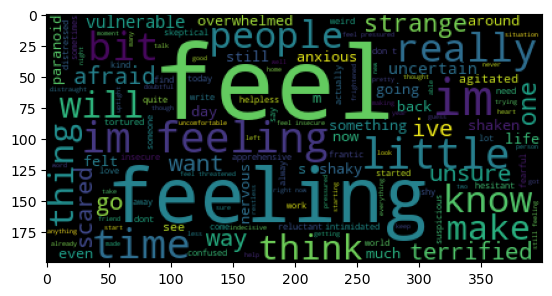

In [61]:
wc = WordCloud().generate(' '.join(fear_data))
plt.imshow(wc)
plt.show()

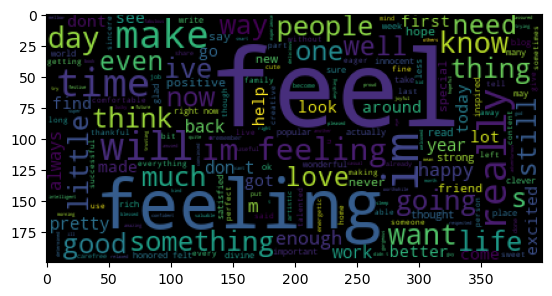

In [62]:
wc = WordCloud().generate(' '.join(joy_data ))
plt.imshow(wc)
plt.show()

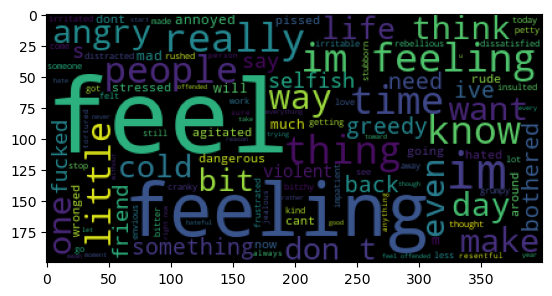

In [63]:
wc = WordCloud().generate(' '.join(anger_data ))
plt.imshow(wc)
plt.show()

In [64]:
fear_words = []
for i in fd:
    if (i not in ad) and (i not in jd):
        fear_words.append(i)

joy_words = []
for i in jd:
    if (i not in ad) and (i not in fd):
        joy_words.append(i)

anger_words = []
for i in ad:
    if (i not in fd) and (i not in jd):
        anger_words.append(i)

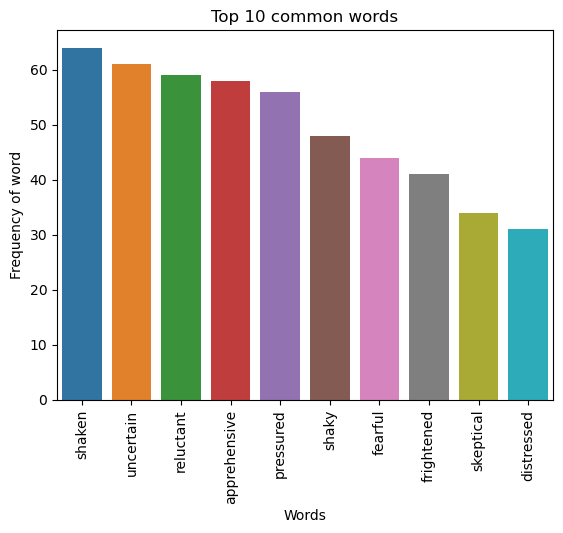

In [65]:
words = []
freq = []
for i,j in Counter(fear_words).most_common(10):
    words.append(i)
    freq.append(j)
sns.barplot(x= words, y= freq)
plt.xlabel('Words')
plt.ylabel('Frequency of word')
plt.title('Top 10 common words')
plt.xticks(rotation = 90)
plt.show()

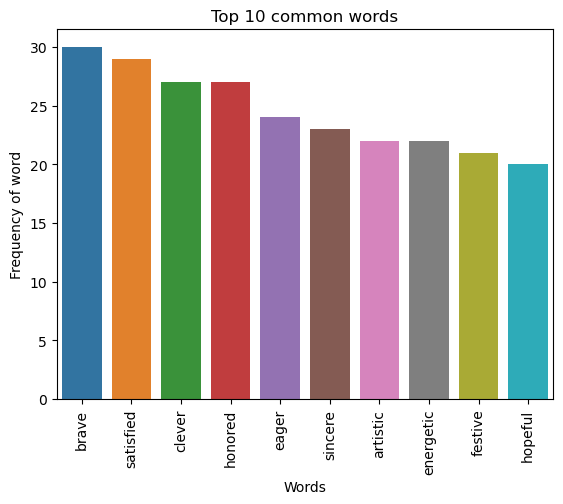

In [66]:
words = []
freq = []
for i,j in Counter(joy_words).most_common(10):
    words.append(i)
    freq.append(j)
sns.barplot(x= words, y= freq)
plt.xlabel('Words')
plt.ylabel('Frequency of word')
plt.title('Top 10 common words')
plt.xticks(rotation = 90)
plt.show()

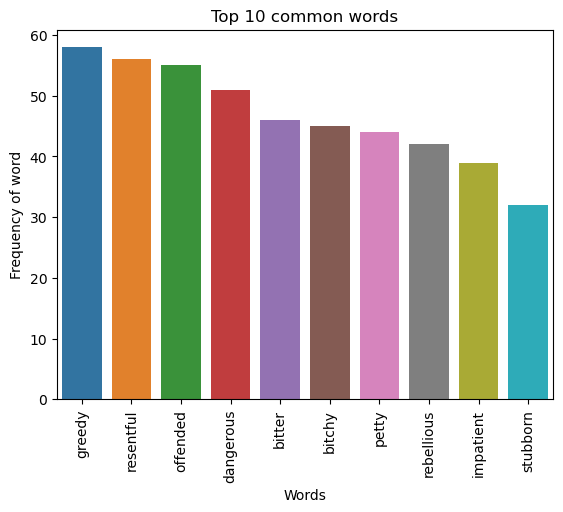

In [68]:
words = []
freq = []
for i,j in Counter(anger_words).most_common(10):
    words.append(i)
    freq.append(j)
sns.barplot(x= words, y= freq)
plt.xlabel('Words')
plt.ylabel('Frequency of word')
plt.title('Top 10 common words')
plt.xticks(rotation = 90)
plt.show()

# 6. Feature Engineering

In [69]:
feature_extraction_pipe = Pipeline([('Pre-Processing',preprocesser_pipe),
                                    ('Vectorization',CountVectorizer(binary= True))])

In [70]:
final_x_train = feature_extraction_pipe.fit_transform(x_train)

final_x_cv = feature_extraction_pipe.transform(x_cv)

final_x_test = feature_extraction_pipe.transform(x_test)

In [71]:
pickle.dump(feature_extraction_pipe,open(r"C:\Users\pavan\Desktop\satya\Machine learning\Projects\Emotion_feature_extraction.pkl",'wb'))


# 7. Training & Evaluation

In [75]:
mb = MultinomialNB()
model=mb.fit(final_x_train,y_train)
predicted=model.predict(final_x_cv)

In [77]:
print(classification_report(y_cv,predicted))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       320
           1       0.86      0.92      0.89       310
           2       0.90      0.84      0.87       320

    accuracy                           0.88       950
   macro avg       0.88      0.88      0.88       950
weighted avg       0.88      0.88      0.88       950



In [78]:
mb = MultinomialNB()
model=mb.fit(final_x_train,y_train)
predicted=model.predict(final_x_train)

In [79]:
print(classification_report(y_train,predicted))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1280
           1       0.97      0.98      0.98      1239
           2       0.99      0.98      0.99      1280

    accuracy                           0.98      3799
   macro avg       0.98      0.98      0.98      3799
weighted avg       0.98      0.98      0.98      3799



# 8. Testing

In [80]:
mb = MultinomialNB(alpha= 1)
final_model = mb.fit(final_x_train,y_train)

In [81]:
print(classification_report(y_test, final_model.predict(final_x_test)))


              precision    recall  f1-score   support

           0       0.89      0.93      0.91       400
           1       0.90      0.92      0.91       388
           2       0.94      0.87      0.90       400

    accuracy                           0.91      1188
   macro avg       0.91      0.91      0.91      1188
weighted avg       0.91      0.91      0.91      1188



# 9. Deploying

In [82]:
pickle.dump(final_model,open(r"C:\Users\pavan\Desktop\satya\Machine learning\Projects\Emotion_model.pkl",'wb'))


# 10. Conclusion

In conclusion, the development of a model for predicting the emotion conveyed in text represents a significant advancement in sentiment analysis. Through the utilization of sophisticated machine learning algorithms and comprehensive datasets, we have the capability to accurately classify text into various emotional categories, ranging from joy and fear and anger.